# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time

# modify to where you store your project data including utils.py
datadir = "/Users/isaac/OneDrive/Desktop/CS445/cs445_proj2_starter_code-2/"

utilfn = datadir + "utils.py"
!copy "$utilfn" .
samplesfn = datadir + "samples"
!copy -r "$samplesfn" .
import utils

The file cannot be copied onto itself.
        0 file(s) copied.
The system cannot find the file specified.


In [4]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [5]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """

    out_image = np.zeros((out_size, out_size, 3), dtype=np.uint8)

    for x in range(0, out_size, patch_size):
        for y in range(0, out_size, patch_size):
            rand_x = random.randint(0, sample.shape[0] - patch_size)
            rand_y = random.randint(0, sample.shape[1] - patch_size)
            diff_x=min(x + patch_size, out_size) - x
            diff_y=min(y + patch_size, out_size) - y
            out_image[x:x+patch_size, y:y+patch_size, :] = sample[rand_x:rand_x + diff_x, rand_y:rand_y + diff_y, :]

    return out_image

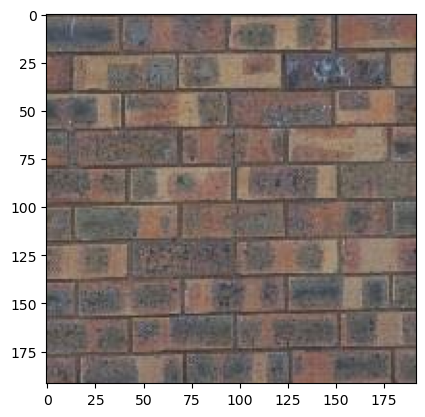

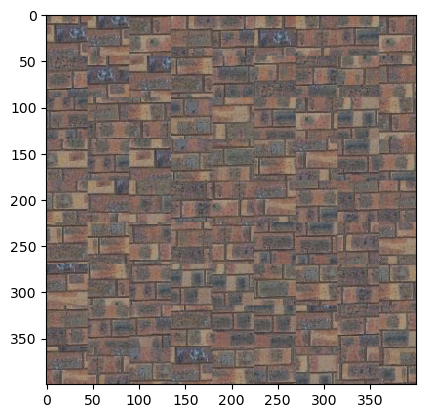

In [6]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 400  # change these parameters as needed
patch_size = 45
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [22]:
def ssd_patch(T, M, I):
    #Mask is the matrix of 0s and 1s that is the size of the patch size. It represents the position of the overlap with 1s. These 1s will be replaced by template values 
    #Template is a matrix that is the same size patch_size. The overlap is filled with pixel values and the empty spots are 0s. 
    #ssd_cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    I = I.astype(np.float32)
    #T = T.astype(np.float32)
    M = M.astype(np.float32)
    
    #ssd_cost = [[np.inf for x in range(I.shape[0])] for y in range(I.shape[1])] 
    #np.zeros((I.shape[0], I.shape[1]))
    
    channel1= ((M[:,:,0]*T[:,:,0])**2).sum() - 2 * cv2.filter2D(I[:,:,0], ddepth=-1, kernel = M[:,:,0]*T[:,:,0]) + cv2.filter2D(I[:,:,0] ** 2, ddepth=-1, kernel=M[:,:,0])
    channel2= ((M[:,:,1]*T[:,:,1])**2).sum() - 2 * cv2.filter2D(I[:,:,1], ddepth=-1, kernel = M[:,:,1]*T[:,:,1]) + cv2.filter2D(I[:,:,1] ** 2, ddepth=-1, kernel=M[:,:,1])
    channel3= ((M[:,:,2]*T[:,:,2])**2).sum() - 2 * cv2.filter2D(I[:,:,2], ddepth=-1, kernel = M[:,:,2]*T[:,:,2]) + cv2.filter2D(I[:,:,2] ** 2, ddepth=-1, kernel=M[:,:,2])
    
    (row, col) = channel1.shape
    ssd_cost = np.zeros((row, col))
    ssd_cost[:,:] = channel1 + channel2 + channel3
    
    
    return np.absolute(ssd_cost[:,:])

In [23]:
"""def choose_sample(tol, ssd_image):
find minimum value within cost as a float
use where to find row col positions of cost values fitting a certain inequality 
take a random row and col position
return that row and col position


The output of this function 
"""

def choose_sample(ssd_image, tol):
    min_cost = np.amin(ssd_image)
    candidates = []
    #print("min_cost: {}".format(min_cost)) 
    for i in range(ssd_image.shape[0]):
        for j in range(ssd_image.shape[1]):
            
            #print("ssd_image[i][j]: {}".format(ssd_image[i,j]))        
            
            candidates.append((ssd_image[i,j],(i, j)))
    candidates = sorted(candidates)
    candidates = candidates[:tol]
    selected_candidates = random.choice(candidates)
    
        
    return selected_candidates[1]

In [24]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray

    """


    sample = sample.astype(np.float32)
    sample = sample/255.0
    #print(np.amax(sample))
    out_image = np.zeros((out_size, out_size, 3), dtype = np.float32)
    step = patch_size - overlap
    half = int(patch_size/2)
    template = np.zeros((patch_size,patch_size, 3))
    for x in range(0, out_size-patch_size, step):
        for y in range(0, out_size-patch_size, step):
            
            template = out_image[x:x + patch_size, y:y + patch_size, :].copy() 
            
            if x == 0 and y == 0:
                rand_x = random.randint(0, sample.shape[0] - patch_size)
                rand_y = random.randint(0, sample.shape[1] - patch_size) 
                out_image[x:x+patch_size, y:y+patch_size, :] = sample[rand_x:rand_x + patch_size, rand_y:rand_y + patch_size, :].copy()
                
            elif (x == 0 and y != 0):# the cases where only columns overlap at some point add the other case
                mask = np.zeros((patch_size, patch_size, 3), dtype = np.float32)
                mask[:,0:overlap,:] = 1.0 
                
                #print("case 1")
                #plt.imshow(mask)
                #plt.show()
                #plt.imshow(template)
                #plt.show()
                #template = out_image[x:x + overlap,:,:].copy()
                
                ssd_image = ssd_patch(template, mask, sample)
 
                
                ssd_image[-patch_size:,:] = float("inf")
                ssd_image[:patch_size,:] = float("inf")
                ssd_image[:,:patch_size] = float("inf")
                ssd_image[:,-patch_size:] = float("inf")
                #plt.imshow(ssd_image)
                #plt.show()
                
                row,col = choose_sample(ssd_image, tol)     

                #print("row {}".format(row))
                #print("col {}".format(col))
                
            
                out_image[x:x+patch_size, y:y+patch_size, :] = sample[row-half:row+half+1, col-half:col+half+1,:].copy()
                #plt.imshow(out_image)
                #plt.show()

            elif x != 0 and y == 0:
                mask = np.zeros((patch_size, patch_size, 3), dtype = np.float32)
                mask[0:overlap,:,:] = 1.0 #
                
                #template = out_image[:,y:y+overlap,:].copy()
                
                ssd_image = ssd_patch(template, mask, sample)
                
                ssd_image[-patch_size:,:] = float("inf")
                ssd_image[:patch_size,:] = float("inf")
                ssd_image[:,:patch_size] = float("inf")
                ssd_image[:,-patch_size:] = float("inf")

                row,col = choose_sample(ssd_image, tol)                
                out_image[x:x+patch_size, y:y+patch_size, :] = sample[row-half:row+half+1, col-half:col+half+1,:].copy()

            else:
                mask = np.zeros((patch_size, patch_size, 3), dtype = np.float32)
                mask[0:overlap,:,:] = 1.0 #
                mask[:,0:overlap,:] = 1.0 
                
                #template = out_image[x:x + overlap, y:y + overlap, :].copy() 
                #plt.imshow(template)
                #plt.show()
                
                ssd_image = ssd_patch(template, mask, sample)
                
                ssd_image[-patch_size:,:] = float("inf")
                ssd_image[:patch_size,:] = float("inf")
                ssd_image[:,:patch_size] = float("inf")
                ssd_image[:,-patch_size:] = float("inf")

                row,col = choose_sample(ssd_image, tol)                
                out_image[x:x+patch_size, y:y+patch_size, :] = sample[row-half:row+half+1, col-half:col+half+1,:].copy()
                #plt.imshow(out_image)
                #plt.show()


    return out_image

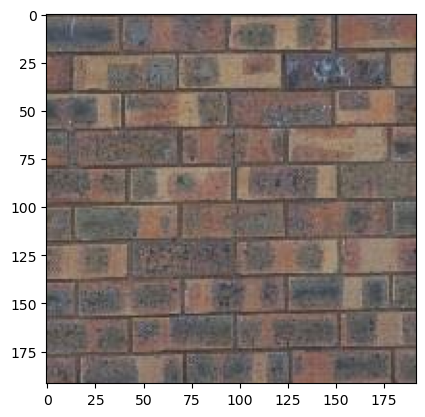

image shape is (192, 192, 3)


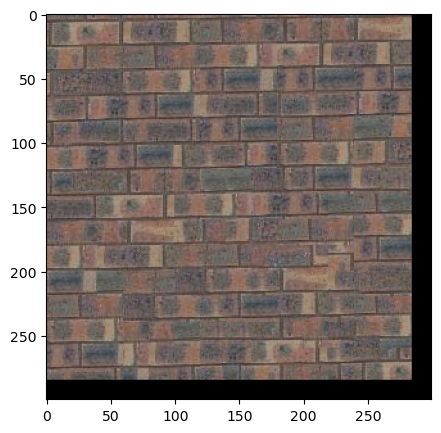

In [25]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

print('image shape is ' + str(np.array(sample_img).shape))

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 5
tol = 1
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)
    

### Part III: Seam Finding (20 pts)


In [26]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [78]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    sample = sample.astype(np.float32)
    sample = sample/255.0
    out_image = np.zeros((out_size, out_size, 3), dtype = np.float32)
    step = patch_size - overlap
    template = np.zeros((patch_size,patch_size, 3))
    half = int(patch_size/2)
    #cost_img = ssd_patch(template, mask, image)
    
    for x in range(0, out_size-patch_size, step):
        for y in range(0, out_size-patch_size, step):
            
            template = out_image[x:x + patch_size, y:y + patch_size, :].copy() 
            
            if x == 0 and y == 0:
                rand_x = random.randint(0, sample.shape[0] - patch_size)
                rand_y = random.randint(0, sample.shape[1] - patch_size) 
                out_image[x:x+patch_size, y:y+patch_size, :] = sample[rand_x:rand_x + patch_size, rand_y:rand_y + patch_size, :].copy()
                
            elif (x == 0 and y != 0):
                mask = np.zeros((patch_size, patch_size, 3), dtype = np.float32)
                mask[:,0:overlap,:] = 1.0 
                
                #print("case 1")
                #plt.imshow(mask)
                #plt.show()
                #plt.imshow(template)
                #plt.show()
                #template = out_image[x:x + overlap,:,:].copy()
                
                ssd_image = ssd_patch(template, mask, sample)
                temp = ssd_image
                
                ssd_image[-patch_size:,:] = float("inf")
                ssd_image[:patch_size,:] = float("inf")
                ssd_image[:,:patch_size] = float("inf")
                ssd_image[:,-patch_size:] = float("inf")
                #plt.imshow(ssd_image)
                #plt.show()
                replace = out_image[y*(patch_size-overlap):y*(patch_size-overlap)+patch_size, : patch_size, :]
                
                
                row,col = choose_sample(ssd_image, tol)  

                
                new_patch = sample[row-half:row+half+1, col-half:col+half+1, :].copy()
                
                diff = replace[:overlap,: patch_size, :]**2 
                diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
                
                mask_cut = cut(diff)
                
                #plt.imshow(mask_cut)
                #plt.show()
                
                #mask_cut = mask.astype(np.uint8)
                
                plt.imshow(mask_cut)
                plt.show()
        
                new_patch[:patch_size,:overlap,0] *= mask_cut
                new_patch[:patch_size,:overlap,1] *= mask_cut
                new_patch[:patch_size,:overlap,2] *= mask_cut

                inv_mask = np.ones(mask.shape)-mask

                replace[:patch_size,:overlap,0] *= inv_mask
                replace[:patch_size,:overlap,1] *= inv_mask
                replace[:patch_size,:overlap,2] *= inv_mask



                out_image += new_patch
                #out_image += new_patch                

    return out_image

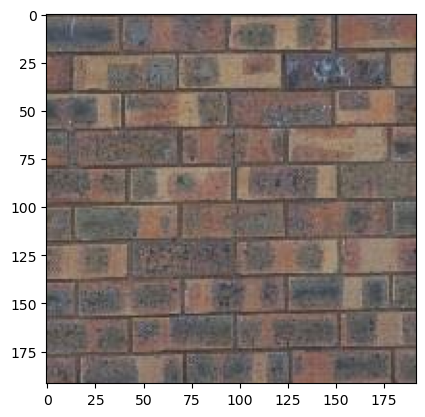

ValueError: attempt to get argmin of an empty sequence

In [79]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 30
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """


In [ ]:
# load/process appropriate input texture and guidance images

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).